In [14]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
import imutils
from imutils.object_detection import non_max_suppression
import time
import cv2
import numpy as np
from sliding_window import sliding_window # this is user defined function
from image_pyramid import image_pyramid # this is user defined function

In [15]:
WIDTH = 600 # resize the images to the size of 600x600
PYR_SCALE = 1.5 # To creating the multiple scaled version of image
WIN_STEP = 16 # Sliding Window step size 
ROI_SIZE = (250,250) # Region of interest (Sub image block) size
INPUT_SIZE = (224, 224) # input image size (We are using mobilenet architecture)
visualize=0 # control parameter for visualizing images
min_conf=0.9 # class probability threshold for the object predicted in each RoI

In [16]:
# Define the pretrained model - Mobilenet
model = MobileNet(weights="imagenet", include_top=True)

In [17]:
orig = cv2.imread('hummingbird.jpg')
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

In [18]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

In [19]:
rois = []
locs = []

In [20]:

start = time.time()
# loop over the image pyramid
for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])

    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if visualize > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 2)

            # show the visualization and current ROI
            cv2.imshow("Visualization", clone)
            cv2.imshow("ROI", roiOrig)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
end = time.time()
print("looping over pyramid/windows took {:.5f} seconds".format(end - start))


looping over pyramid/windows took 0.10452 seconds


In [21]:

rois = np.array(rois, dtype="float32") 

In [22]:
rois.shape #Total of 132 regions of each size 224x224x3 

(132, 224, 224, 3)

In [23]:
# Predicting the class of each ROI using the mobilenet model
print("classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("classifying ROIs took {:.5f} seconds".format(end - start))

classifying ROIs...
classifying ROIs took 3.36117 seconds


In [24]:
preds.shape # Probability of each ROI towards 1000 classes (Mobilenet trained for 1000 classes)

(132, 1000)

In [25]:
preds = imagenet_utils.decode_predictions(preds, top=1) # top probability prediction

In [27]:
#preds

In [28]:
#create a dictionary with key name as predicted class name (predicted with more than 0.9 confidence)
#keyvalues are its corresponding bounding boxes and probability
labels = {}
for (i, p) in enumerate(preds):
    im_id,obj,prob=p[0]
    if prob>0.9:
        bb=locs[i]
        L=labels.get(obj,[])
        L.append((bb, prob))
        labels[obj] = L

In [29]:
labels

{'hummingbird': [((0, 0, 250, 250), 0.9984376),
  ((16, 0, 266, 250), 0.9995128),
  ((32, 0, 282, 250), 0.99854565),
  ((48, 0, 298, 250), 0.99987113),
  ((64, 0, 314, 250), 0.99965084),
  ((80, 0, 330, 250), 0.9998379),
  ((96, 0, 346, 250), 0.9995864),
  ((112, 0, 362, 250), 0.998059),
  ((128, 0, 378, 250), 0.9845227),
  ((144, 0, 394, 250), 0.9605412),
  ((160, 0, 410, 250), 0.9584896),
  ((0, 16, 250, 266), 0.99821126),
  ((16, 16, 266, 266), 0.9995216),
  ((32, 16, 282, 266), 0.9994491),
  ((48, 16, 298, 266), 0.999716),
  ((64, 16, 314, 266), 0.99962544),
  ((80, 16, 330, 266), 0.9998647),
  ((96, 16, 346, 266), 0.9992186),
  ((112, 16, 362, 266), 0.99739146),
  ((128, 16, 378, 266), 0.9492388),
  ((0, 32, 250, 282), 0.9977354),
  ((16, 32, 266, 282), 0.99934083),
  ((32, 32, 282, 282), 0.9977678),
  ((48, 32, 298, 282), 0.99983394),
  ((64, 32, 314, 282), 0.9997546),
  ((80, 32, 330, 282), 0.9997955),
  ((96, 32, 346, 282), 0.9995709),
  ((112, 32, 362, 282), 0.99735934),
  ((1

In [30]:
labels.keys()

dict_keys(['hummingbird', 'jellyfish'])

In [31]:
boxes1=[]
lab=[]
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    cv2.imshow("Before", clone)
    cv2.waitKey(0)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    boxes1.append(boxes)
    lab.append(label)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    # show the output after apply non-maxima suppression
    cv2.imshow("After", clone)
    cv2.waitKey(0);
    cv2.destroyAllWindows()

showing results for 'hummingbird'
showing results for 'jellyfish'


In [33]:
len(boxes1),lab # After non max supression, at last two objects are present in the image

(2, ['hummingbird', 'jellyfish'])

In [34]:
clone = orig.copy()
for i in range(len(boxes1)):
    bb=boxes1[i][0]
    cv2.rectangle(clone, (bb[0], bb[1]), (bb[2], bb[3]),(0, 255, 0), 2)
    y = bb[1] - 10 if bb[1] - 10 > 10 else bb[1] + 10
    cv2.putText(clone, lab[i], (bb[0], y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    cv2.imshow("Final Objects", clone)
    cv2.waitKey(0);cv2.destroyAllWindows()

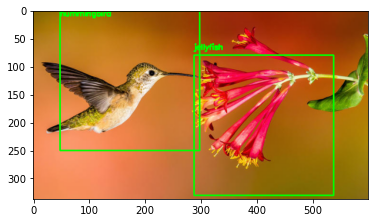

In [38]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()

In the above result, humming bird is correctly detected, but the flower is wrongly detected as jelly fish (ofcourse its look like jelly fish). This is because mobilenet is not trained for this type of flower. Retrain the part of mobilenet weights (Transfer Learning) using some images of these type of flowers can make this model to predict the flower object correctly.